In [2]:
pip install pulp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 17.4 MB/s eta 0:00:00


Enter the value for demand mean: 100
Enter the value for demand standard deviation: 30
Enter the value for cost per unit: 60
Enter the value for maximum price: 160
Enter the value for minimum price: 90
Enter the value for initial price: 200
Enter the value for holding cost per unit (optional): 3000


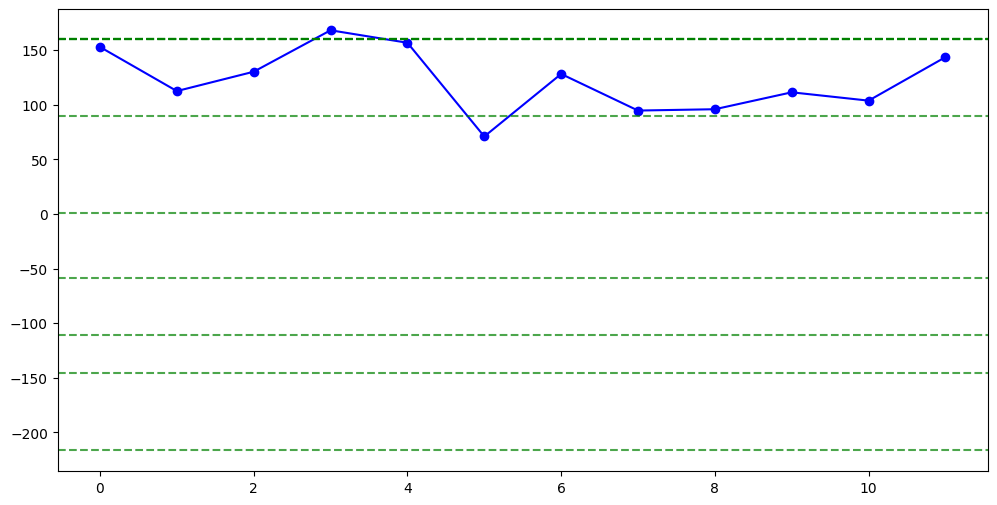

In [5]:
1import numpy as np
import matplotlib.pyplot as plt
from pulp import *

def get_user_input(param_name, validation_func=None):

  while True:
    user_input = input(f"Enter the value for {param_name}: ")
    try:
      if validation_func is not None:
        if validation_func(user_input):
          return float(user_input)
        else:
          print(f"Invalid input for {param_name}. Please try again.")
      else:
        return float(user_input)
    except ValueError:
      print(f"Invalid input for {param_name}. Please enter a valid number.")

np.random.seed(0)
num_periods = 12  # Consider 12 periods for potential seasonality
demand_mean = get_user_input("demand mean")
demand_std = get_user_input("demand standard deviation", lambda x: float(x) > 0)
seasonality_factor = np.sin(2 * np.pi * np.arange(num_periods) / 11)  # Simple sinusoidal seasonality
demand = demand_mean + demand_std * np.random.randn(num_periods) + seasonality_factor

cost_per_unit = get_user_input("cost per unit", lambda x: float(x) >= 0)
max_price = get_user_input("maximum price", lambda x: float(x) > 0)
min_price = get_user_input("minimum price", lambda x: float(x) >= 0 and float(x) <= max_price)
initial_price = get_user_input("initial price")
holding_cost = get_user_input("holding cost per unit (optional)", lambda x: float(x) >= 0)  # Optional holding cost

prob = LpProblem("Dynamic_Pricing_Inventory", LpMaximize)

price = LpVariable.dicts("Price", range(num_periods), lowBound=min_price, upBound=max_price)
inventory = LpVariable.dicts("Inventory", range(num_periods), lowBound=0)

objective = price[0] * demand[0] - cost_per_unit * demand[0]
if holding_cost:
  for i in range(1, num_periods):
    objective += price[i] * demand[i] - cost_per_unit * demand[i] - holding_cost * inventory[i - 1]
else:
  for i in range(1, num_periods):
    objective += price[i] * demand[i] - cost_per_unit * demand[i]
prob += objective

for i in range(num_periods):
  if i == 0:
    prob += inventory[i] == initial_price - cost_per_unit - price[i] * demand[i]  # Initial inventory constraint
  else:
    prob += inventory[i] == inventory[i - 1] + price[i - 1] * demand[i - 1] - cost_per_unit * demand[i] - price[i] * demand[i]  # Inventory balance constraint

prob.solve()

optimal_prices = {}
optimal_inventory = {}
for i in range(num_periods):
  optimal_prices[i] = value(price[i])
  optimal_inventory[i] = value(inventory[i])

if num_periods <= 20:
  plt.figure(figsize=(12, 6))
  plt.plot(range(num_periods), demand, marker='o', linestyle='-', color='b', label='Demand')
  for i in range(num_periods):
    plt.axhline(y=optimal_prices[i], color='g', linestyle='--', alpha=0.7, label=f'Price_Period_{i+1}')
  if holding_cost:
    inventory_values = [optimal_inventory[i] for i in range(num_periods)]  # Extract inventory as a list
